    0         1         2         3         4         5         6         7   \
0  0.0 -0.335016 -0.043081  0.274072 -0.664478 -0.844129 -0.409724 -0.125023   
1  0.0 -0.335016 -1.094937  0.038648  0.268751 -0.138020 -0.409724 -0.125023   
2  0.0 -0.335016 -1.094937 -1.844742  0.735366  1.097673 -0.409724 -0.125023   
3  0.0 -0.335016  0.377661  0.744919  0.268751 -0.844129 -0.409724 -0.125023   
4  0.0 -0.335016 -1.094937 -2.551014 -0.197863 -1.020657 -0.409724 -0.125023   

         8         9     ...           54        55        56        57  \
0 -0.059078 -0.624009    ...    -0.757436 -0.209785 -0.023596 -0.299081   
1 -0.059078 -0.624009    ...    -0.757436 -0.209785 -0.023596 -0.299081   
2 -0.059078 -0.624009    ...     0.259230 -0.209785 -0.023596 -0.299081   
3 -0.059078  1.879691    ...     1.072563 -0.209785 -0.023596 -0.299081   
4 -0.059078 -0.624009    ...    -0.757436 -0.209785 -0.023596 -0.299081   

         58        59        60        61        62        63  
0  0

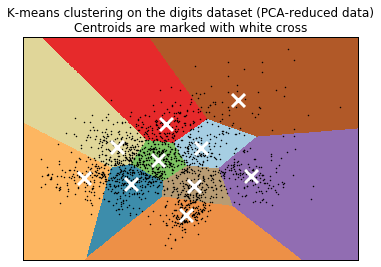

In [33]:

from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)
data_fr = pd.DataFrame(data)
print(data_fr.head())

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Total running time of the example: 2.26 seconds ( 0 minutes 2.26 seconds)
# © 2010 - 2014, scikit-learn developers (BSD License). Show this page source
# Previous


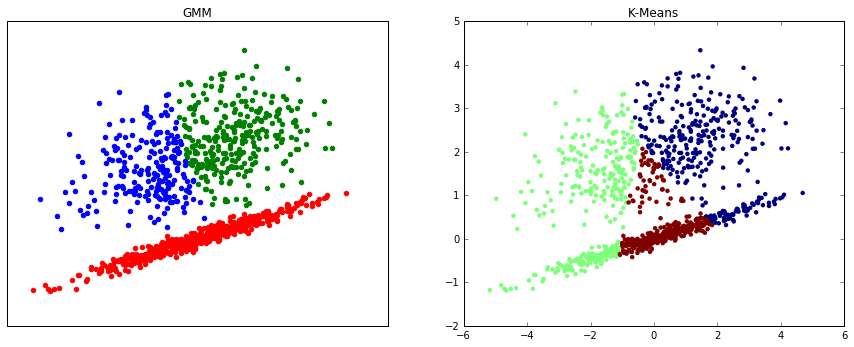

In [85]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12)

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from matplotlib.colors import LogNorm

from sklearn import mixture

# Number of samples per component
n_samples = 500

# iris = datasets.load_iris()
# X = iris.data

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2)  + np.dot(np.random.randn(n_samples, 2), C) + np.array([0, 2])]

# Fit a mixture of Gaussians with EM using five components
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(X)

gmm = mixture.GMM(n_components=3, covariance_type='full')
gmm.fit(X)


color_iter = itertools.cycle(['r', 'g', 'b'])

for i, (clf, title) in enumerate([(gmm, 'GMM')]):
    splot = plt.subplot(2, 2, 1 + i)
    Y_ = clf.predict(X)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1],  color=color)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

y_pred = kmeans.predict(X)
plt.subplot(2,2,2)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,color=['b','r','g'],lw=0, edgecolors='none')
plt.title("K-Means")

plt.show()